In [1]:
import numpy as np
import pandas as pd
from collections import deque
import ast
import os
import glob
from pathlib import Path
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
)

from functions import(
    ast_df,
    is_central_stations,
)


In [192]:
events_file = '../output/events_reconstruction.csv'
kascade_folder = './KASCADE_Experiment/Ne/'


coordinates_df = pd.read_csv(COORDINATES_PATH)
kascade1_df = pd.read_csv('../KASCADE_Experiment/Ne/43-47.csv', sep=r',\s*', engine='python')
kascade2_df = pd.read_csv('../KASCADE_Experiment/Ne/47-51.csv', sep=r',\s*', engine='python')
kascade3_df = pd.read_csv('../KASCADE_Experiment/Ne/39-43.csv', sep=r',\s*', engine='python')



events_df = pd.read_csv(events_file)
event_df = ast_df(events_df)
events_df.head(1)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
0,836,6627,63.67,116.71,33.168543,-80.0,5468.278104,1.441416,0.63366,6,6,5,0,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N..."


In [3]:
loss = np.array(events_df['loss'])
X0 = np.array(events_df['X0_opt'])
YO = np.array(events_df['Y0_opt'])
Ne = np.array(events_df['Ne_opt'])
s = np.array(events_df['s_opt'])

In [149]:
n = 2
f_events_df = events_df[events_df.apply(lambda row: is_central_stations(row, n), axis=1)]

In [150]:
f_events_df1 = f_events_df[
    (f_events_df['X0_opt'] > -20) & (f_events_df['X0_opt'] < 20) &
    (f_events_df['Y0_opt'] > -40) & (f_events_df['Y0_opt'] < 40) &
    (f_events_df['loss'] < 1) &
    (f_events_df['s_opt'] < 1.9) & (f_events_df['s_opt'] > 1.2) &
    (f_events_df['Ne_opt'] < 10 ** 5.0) & (f_events_df['Ne_opt'] >  10 ** 4)
    
]

In [151]:
f_events_df1.head(2)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
37,836,382082,40.02,135.32,-6.138922,24.673758,12842.777020,1.263052,0.311486,6,5,5,0,6,"[1, 2, 3, 4, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.8693000637755104, 0.14813190901360543, 0.41...","[222.336, 45.291, 125.61, 213.205, 170.027, 24...","[130.854, 22.298, 62.871, 159.539, 102.379, 15...","[2348.947, 2339.103, 2351.6, 2369.482, 2352.58..."
38,836,394725,41.86,195.02,-12.352888,2.792757,12414.746474,1.607446,0.448583,5,4,4,0,5,"[1, 2, 3, 4, 5, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.6225353422619048, 0.6518720769557823, 1.229...","[189.995, 133.803, 271.537, 155.008, 131.456, ...","[93.709, 98.125, 185.12, 82.022, 82.099, 62.04...","[2380.526, 2352.518, 2348.377, 2377.677, 2372...."


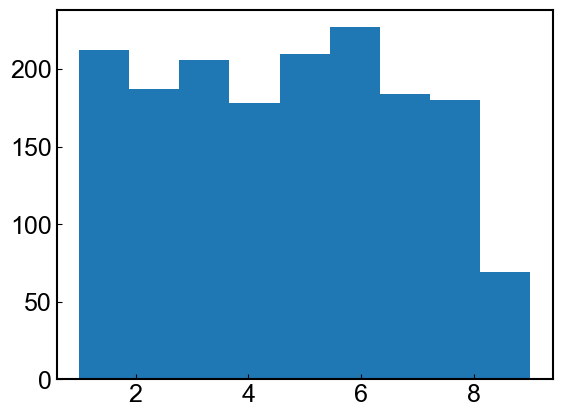

In [199]:
count = [len(cl) for cl in f_events_df['worked_clusters']]
plt.hist(count, bins=9)
plt.show()

In [153]:
Z0 = 0

row = f_events_df1.iloc[3]
nevent = row['NEvent']
nview = row['Nview']
theta = row['Theta'] 
phi = row['Phi']
rho = row['rho']
Ne = row['Ne_opt']
s = row['s_opt']


station_flags = row['station_flags']
worked_station_indices = [i for i, flag in enumerate(station_flags) if flag]

worked_coords = coordinates_df.iloc[worked_station_indices]

r = []
for _, station in worked_coords.iterrows():
    r.append(compute_r(
        float(row['X0_opt']), float(row['Y0_opt']), float(Z0),
        float(theta), float(phi),
        float(station['X']), float(station['Y']), float(station['Z'])
    )
    )

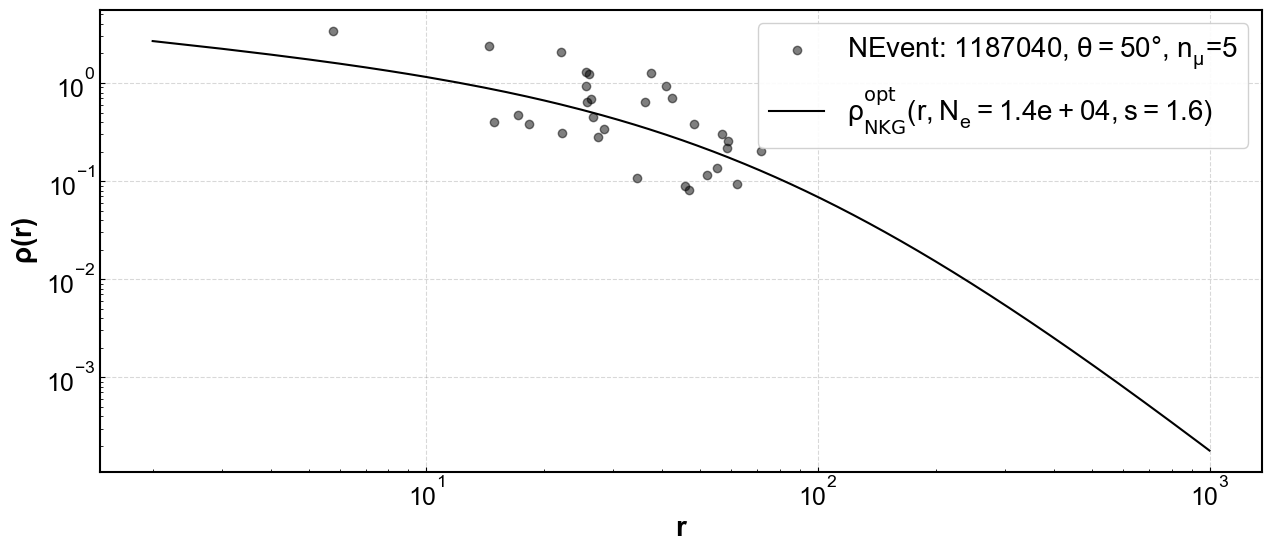

In [154]:
r_enterval= np.arange(2, 1e3, 1)
rho_calculate = rho_model(r_enterval, Ne, s)


plt.figure(figsize=(15, 6))
plt.scatter(r, rho, alpha=0.5, color='black', label=rf'NEvent: {nevent}, $\theta =${theta:.0f}$\degree$, $n_{{\mu}}$={nview}')

plt.plot(r_enterval, rho_calculate, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne:.1e}, s={s:.1f})$')


plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
# plt.savefig(f'plots/{163010}/event_{j_event}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

In [155]:
Z0 = 0
all_rs, all_rs2= [], []
all_rhos, all_rhos2 = [], []
all_s, all_s2 = [], []
all_Ne, all_Ne2 = [], []

for _, row in f_events_df1.iterrows():
    theta, phi = row['Theta'], row['Phi']
    station_flags = row['station_flags']
    worked_idx = [i for i, f in enumerate(station_flags) if f]
    coords = coordinates_df.iloc[worked_idx]
    rho_vals = row['rho']
    rs = [
        compute_r(
            row['X0_opt'], row['Y0_opt'], Z0,
            theta, phi,
            float(stat['X']), float(stat['Y']), float(stat['Z'])
        )
        for _, stat in coords.iterrows()
    ]
    if len(rs) != len(rho_vals):
        continue
    all_rs.extend(rs)
    all_rhos.extend(rho_vals)
    all_s.extend([row['s_opt'] ] * len(rs))
    all_Ne.extend([row['Ne_opt']]* len(rs))
    
Ne_low = 1e4
Ne_hight = 1e5
s_val = 1.5
rho_calculate_low = rho_model(r_enterval, Ne=Ne_low, s=s_val)
rho_calculate_hight = rho_model(r_enterval, Ne=Ne_hight, s=s_val)

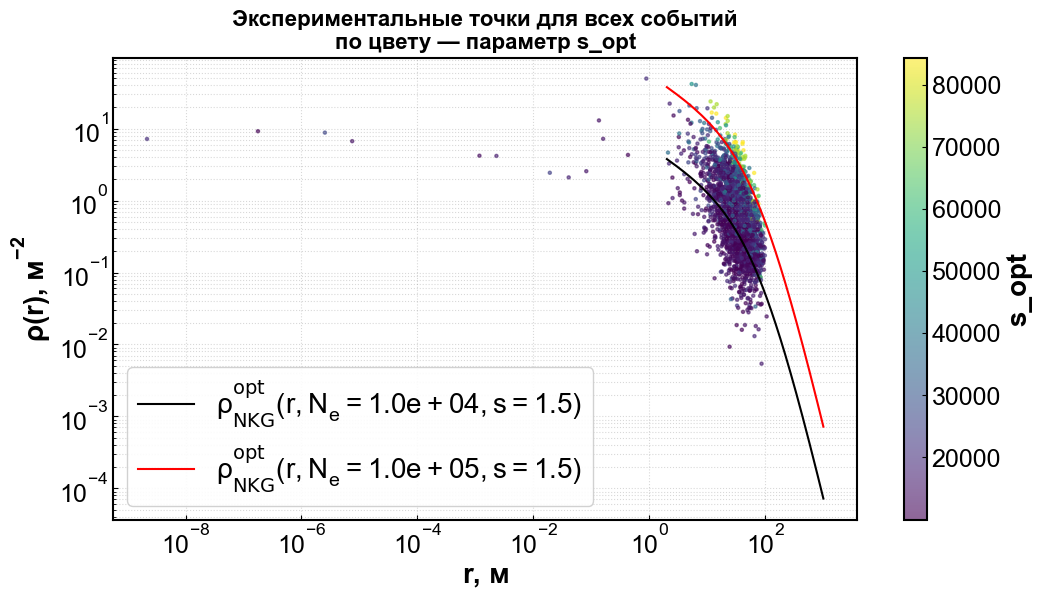

In [156]:
plt.figure(figsize=(12,6))

plt.plot(r_enterval, rho_calculate_low, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_low:.1e}, s={s_val:.1f})$')
plt.plot(r_enterval, rho_calculate_hight, c='red', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

sc = plt.scatter(all_rs, all_rhos, c=all_Ne, cmap='viridis', s=5, alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.colorbar(sc, label='s_opt')
plt.xlabel(r'$r$, м'); plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.title('Экспериментальные точки для всех событий\nпо цвету — параметр s_opt')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

In [194]:
r_kascade1 = kascade1_df['r']
r_kascade2 = kascade2_df['r']
r_kascade3 = kascade3_df['r']


rho_kascade1 = kascade1_df['rho']
rho_kascade2 = kascade2_df['rho']
rho_kascade3 = kascade3_df['rho']


C:\Users\matsvei\AppData\Local\Temp\ipykernel_25440\3267672334.py:16: RuntimeWarning: invalid value encountered in divide
  mean_rho = bin_sums / bin_counts
C:\Users\matsvei\AppData\Local\Temp\ipykernel_25440\3267672334.py:18: RuntimeWarning: invalid value encountered in divide
  std_rho = np.sqrt(bin_sumsq / bin_counts - mean_rho**2)


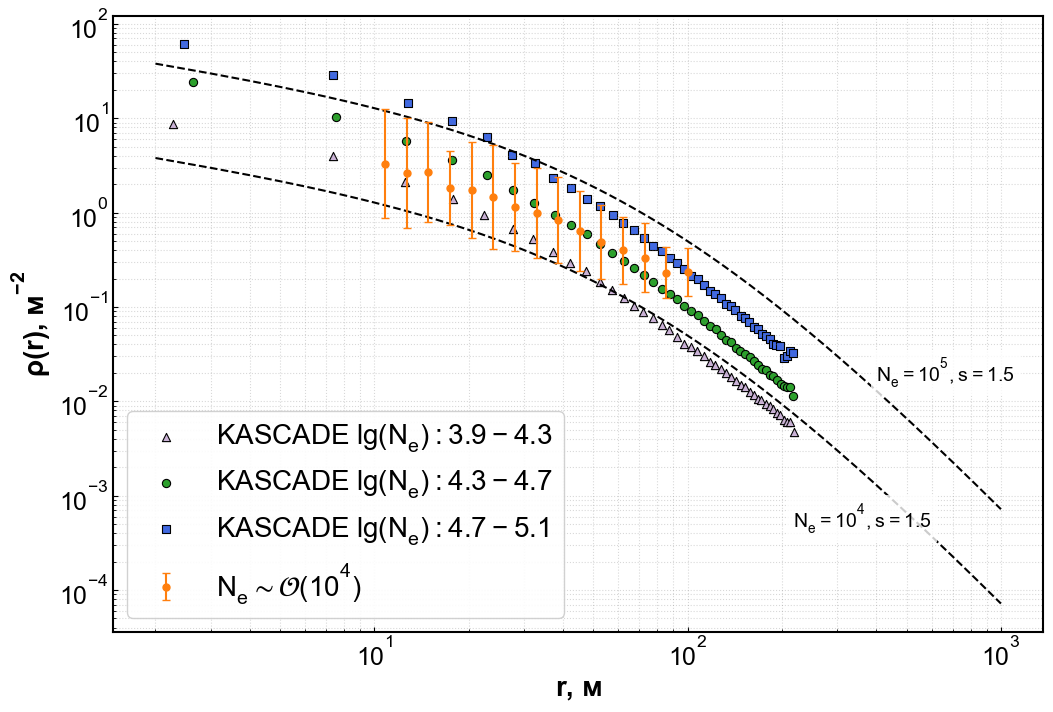

In [197]:

r_bins = np.logspace(np.log10(10), np.log10(1000), 30)
bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])

bin_sums = np.zeros(len(bin_centers))
bin_counts = np.zeros(len(bin_centers))
bin_sumsq = np.zeros(len(bin_centers))

for r_val, rho_val in zip(all_rs, all_rhos):
    idx = np.searchsorted(r_bins, r_val) - 1
    if 0 <= idx < len(bin_centers):
        bin_sums[idx] += rho_val
        bin_sumsq[idx] += rho_val**2
        bin_counts[idx] += 1

# Усреднение и стандартное отклонение
mean_rho = bin_sums / bin_counts
mean_rho = mean_rho
std_rho = np.sqrt(bin_sumsq / bin_counts - mean_rho**2)

# Пересчет ошибок для логарифмического масштаба
log_mean = np.log10(mean_rho)
log_std = std_rho / (mean_rho * np.log(10))  # Приближенно для малых отклонений

# Верхняя и нижняя границы ошибок в логарифмическом масштабе
yerr_lower = mean_rho - 10**(log_mean - log_std)
yerr_upper = 10**(log_mean + log_std) - mean_rho

yerr_lower = np.abs(yerr_lower)
yerr_upper = np.abs(yerr_upper)


# Построение графика
plt.figure(figsize=(12, 8))
# plt.plot(r_enterval, rho_calculate, c='black', 
#          label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

line1, = plt.plot(r_enterval, rho_calculate_low, c='black', linestyle='--')
line2, = plt.plot(r_enterval, rho_calculate_hight, c='black', linestyle='--')

# Функция для умного размещения текста
def add_label(line, text, x_pos=0.5, pos='right'):
    y_pos = np.interp(x_pos, r_enterval, line.get_ydata())
    plt.text(x_pos, y_pos, text, 
             color=line.get_color(),
             ha=pos, va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontsize=14)

# Добавляем подписи (x_pos - положение по оси X в линейных координатах)
add_label(line1, fr'$N_e=10^{{{int(np.log10(Ne_low))}}},s=1.5$', x_pos=600, pos='right')
add_label(line2, fr'$N_e=10^{{{int(np.log10(Ne_hight))}}},s=1.5$', x_pos=400, pos='left')

plt.scatter(r_kascade3, rho_kascade3,  edgecolor='black', 
           linewidths=0.8, color='#cab2d6', alpha=1, s=35, marker='^', label=r'KASCADE $lg(N_e):3.9-4.3$')
plt.scatter(r_kascade1, rho_kascade1, edgecolor='black', 
           linewidths=0.8, color='#2ca02c', alpha=1, s=35, label=r'KASCADE $lg(N_e):4.3-4.7$')
plt.scatter(r_kascade2, rho_kascade2,  edgecolor='black', 
           linewidths=0.8, color='royalblue', alpha=1, s=35, marker='s', label=r'KASCADE $lg(N_e):4.7-5.1$')


plt.errorbar(bin_centers, mean_rho, yerr=[yerr_lower, yerr_upper], color='#ff7f0e',
             fmt='o', capsize=3, markersize=5,   label=r'$N_e \sim \mathcal{O} (10^4)$')



plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.legend()
plt.show()


In [ ]:
len()

C:\Users\matsvei\AppData\Local\Temp\ipykernel_25440\3455764055.py:16: RuntimeWarning: invalid value encountered in divide
  mean_rho = bin_sums / bin_counts
C:\Users\matsvei\AppData\Local\Temp\ipykernel_25440\3455764055.py:17: RuntimeWarning: invalid value encountered in divide
  std_rho  = np.sqrt(bin_sumsq/bin_counts - mean_rho**2)


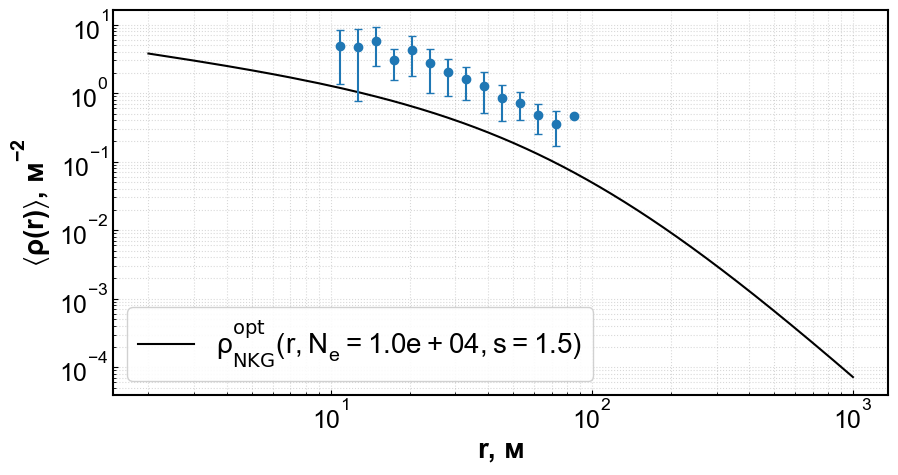

In [95]:
r_bins = np.logspace(np.log10(10), np.log10(1000), 30) 
bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])

bin_sums = np.zeros(len(bin_centers))
bin_counts = np.zeros(len(bin_centers))
bin_sumsq = np.zeros(len(bin_centers))

for r_val, rho_val in zip(all_rs, all_rhos):
    idx = np.searchsorted(r_bins, r_val) - 1
    if 0 <= idx < len(bin_centers):
        bin_sums[idx]   += rho_val
        bin_sumsq[idx]  += rho_val**2
        bin_counts[idx] += 1

# Усреднение и стандартное отклонение
mean_rho = bin_sums / bin_counts
std_rho  = np.sqrt(bin_sumsq/bin_counts - mean_rho**2)
# График с погрешностями
plt.figure(figsize=(10,5))

# plt.plot(r_enterval, rho_calculate_low, c='black', 
#          label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_low:.1e}, s={s_val:.1f})$')
plt.plot(r_enterval, rho_calculate_low, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_low:.1e}, s={s_val:.1f})$')


plt.errorbar(bin_centers, mean_rho, yerr=std_rho, fmt='o', capsize=3)
plt.xscale('log'); plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м'); plt.ylabel(r'$\langle\rho(r)\rangle$, м$^{-2}$')
plt.legend()
# plt.title('Усреднённая LDF с оценкой разброса')
plt.show()

In [71]:
plt.figure(figsize=(15, 6))
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

<Figure size 1500x600 with 0 Axes>

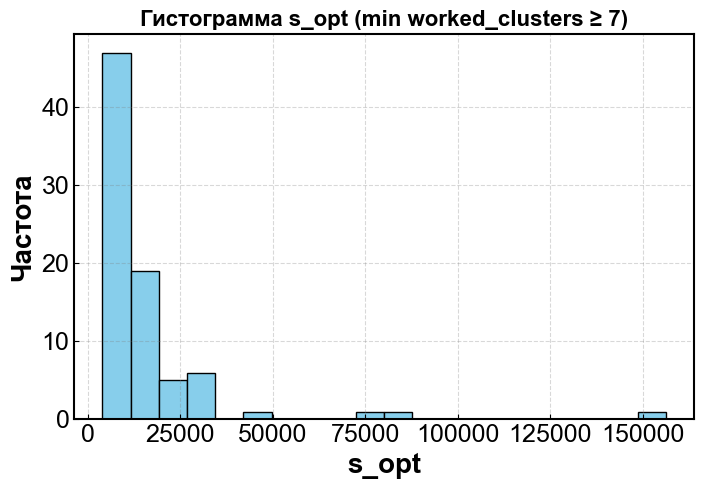

In [ ]:
min_clusters = 7

clusters_count = np.array([len(wc) for wc in f_events_df1['worked_clusters']])

filtered_s = f_events_df1['Ne_opt'][clusters_count >= min_clusters]

# Строим гистограмму
plt.figure(figsize=(8, 5))
plt.hist(filtered_s, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Гистограмма s_opt (min worked_clusters ≥ {min_clusters})')
plt.xlabel('s_opt')
# plt.xscale('log')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [63]:
coordinates_df.head(1)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
